In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from itertools import product
from sklearn.metrics import mean_squared_error
import pmdarima as pm
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [4]:
data1= pd.read_csv('datasets/08_01_Juvenile_apprehended_state_IPC.csv')
data2= pd.read_csv('datasets/08_02_Juvenile_apprehended_state_SLL.csv')
data3= pd.read_csv('datasets/09_Juveniles_arrested_and_their_disposal.csv')
data4= pd.read_csv('datasets/18_01_Juveniles_arrested_Education.csv')
data5= pd.read_csv('datasets/18_02_Juveniles_arrested_Economic_setup.csv')
data6= pd.read_csv('datasets/18_03_Juveniles_arrested_Family_background.csv')
data7= pd.read_csv('datasets/18_04_Juveniles_arrested_Recidivism.csv')

IPC stands for Indian Penal Code, which is the primary criminal code of India. It covers crimes and punishments for various offenses such as murder, theft, rape, and other criminal activities.

In [5]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10500 entries, 0 to 10499
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   STATE/UT                        10500 non-null  object
 1   Year                            10500 non-null  int64 
 2   CRIME                           10500 non-null  object
 3   Boys 7-12 Years                 10500 non-null  int64 
 4   Girls 7-12 Years                10500 non-null  int64 
 5   Boys 12-16 Years                10500 non-null  int64 
 6   Girls 12-16 Years               10500 non-null  int64 
 7   Boys 16-18 Years                10500 non-null  int64 
 8   Girls 16-18 Years               10500 non-null  int64 
 9   Total for boys all Age Groups   10500 non-null  int64 
 10  Total for girls all Age Groups  10500 non-null  int64 
 11  Grand total                     10500 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 984.5+ K

SLL stands for Special Leave to Appeal, which is a provision under the Indian law that allows a party to appeal to the Supreme Court of India against any decision of a High Court. It is not a legal code, but rather a legal provision that allows parties to challenge decisions of lower courts in certain circumstances.

In [6]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9450 entries, 0 to 9449
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   STATE/UT                        9450 non-null   object
 1   Year                            9450 non-null   int64 
 2   CRIME                           9450 non-null   object
 3   Boys 7-12 Years                 9450 non-null   int64 
 4   Girls 7-12 Years                9450 non-null   int64 
 5   Boys 12-16 Years                9450 non-null   int64 
 6   Girls 12-16 Years               9450 non-null   int64 
 7   Boys 16-18 Years                9450 non-null   int64 
 8   Girls 16-18 Years               9450 non-null   int64 
 9   Total for boys all Age Groups   9450 non-null   int64 
 10  Total for girls all Age Groups  9450 non-null   int64 
 11  Grand total                     9450 non-null   int64 
dtypes: int64(10), object(2)
memory usage: 886.1+ KB


#1. Given state, crime(mapping required, not considered for now), age, gender, can we predict possibility of SLL(Naive bias using above data + ARIMA to predict current year using previuos year data).

Processing data

In [7]:
data1_cleaned_task1=data1.drop('CRIME',axis=1)
data1_cleaned_task1=data1_cleaned_task1.groupby(['STATE/UT','Year']).sum().reset_index()

In [8]:
data2_cleaned_task1=data2.drop('CRIME',axis=1)
data2_cleaned_task1=data2_cleaned_task1.groupby(['STATE/UT','Year']).sum().reset_index()

In [9]:
data_task_1=pd.merge(data2_cleaned_task1,data1_cleaned_task1,on=['STATE/UT','Year'],how='inner')
data_task_1['7-12 Years SLL']=data_task_1['Boys 7-12 Years_x']+data_task_1['Girls 7-12 Years_x']
data_task_1=data_task_1.drop(['Boys 7-12 Years_x','Girls 7-12 Years_x'],axis=1)
data_task_1['12-16 Years SLL']=data_task_1['Boys 12-16 Years_x']+data_task_1['Girls 12-16 Years_x']
data_task_1=data_task_1.drop(['Boys 12-16 Years_x','Girls 12-16 Years_x'],axis=1)
data_task_1['16-18 Years SLL']=data_task_1['Boys 16-18 Years_x']+data_task_1['Girls 16-18 Years_x']
data_task_1=data_task_1.drop(['Boys 16-18 Years_x','Girls 16-18 Years_x'],axis=1)

In [10]:
data_task_1['7-12 Years No SLL']=data_task_1['Boys 7-12 Years_y']+data_task_1['Girls 7-12 Years_y']-data_task_1['7-12 Years SLL']
data_task_1['12-16 Years No SLL']=data_task_1['Boys 12-16 Years_y']+data_task_1['Girls 12-16 Years_y']-data_task_1['12-16 Years SLL']
data_task_1['16-18 Years No SLL']=data_task_1['Boys 16-18 Years_y']+data_task_1['Girls 16-18 Years_y']-data_task_1['16-18 Years SLL']
data_task_1['Boys No SLL']=data_task_1['Total for boys all Age Groups_y']-data_task_1['Total for boys all Age Groups_x']
data_task_1['Girls No SLL']=data_task_1['Total for girls all Age Groups_y']-data_task_1['Total for girls all Age Groups_x']
data_task_1['Total No SLL']=data_task_1['Grand total_y']-data_task_1['Grand total_x']

In [11]:
data_task_1=data_task_1.drop(['Boys 7-12 Years_y','Girls 7-12 Years_y'],axis=1)
data_task_1=data_task_1.drop(['Boys 12-16 Years_y','Girls 12-16 Years_y'],axis=1)
data_task_1=data_task_1.drop(['Boys 16-18 Years_y','Girls 16-18 Years_y'],axis=1)
data_task_1=data_task_1.drop(['Total for boys all Age Groups_y','Total for girls all Age Groups_y'],axis=1)

In [12]:
data_task_1.rename(columns = {'Total for boys all Age Groups_x':'Boys SLL','Total for girls all Age Groups_x':'Girls SLL'}, inplace = True)
data_task_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 350 entries, 0 to 349
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   STATE/UT            350 non-null    object
 1   Year                350 non-null    int64 
 2   Boys SLL            350 non-null    int64 
 3   Girls SLL           350 non-null    int64 
 4   Grand total_x       350 non-null    int64 
 5   Grand total_y       350 non-null    int64 
 6   7-12 Years SLL      350 non-null    int64 
 7   12-16 Years SLL     350 non-null    int64 
 8   16-18 Years SLL     350 non-null    int64 
 9   7-12 Years No SLL   350 non-null    int64 
 10  12-16 Years No SLL  350 non-null    int64 
 11  16-18 Years No SLL  350 non-null    int64 
 12  Boys No SLL         350 non-null    int64 
 13  Girls No SLL        350 non-null    int64 
 14  Total No SLL        350 non-null    int64 
dtypes: int64(14), object(1)
memory usage: 43.8+ KB


Checking error of parima

In [13]:
#dataframe to store prediction
data_task_1_arima=data_task_1.groupby(['STATE/UT']).sum().reset_index()
data_task_1_arima.drop('Year',axis=1,inplace=True)

In [14]:
data_task_1_test=data_task_1[data_task_1['Year']!=2010]
data_task_1_real=data_task_1[data_task_1['Year']==2010]

In [15]:
for i in tqdm(data_task_1['STATE/UT'].unique()):
  data_task_1_temp=data_task_1_test[data_task_1_test['STATE/UT']==i]
  for j in ['Boys SLL', '7-12 Years SLL', '12-16 Years SLL', '16-18 Years SLL', '7-12 Years No SLL', '12-16 Years No SLL', '16-18 Years No SLL', 'Boys No SLL']:
    data_task_1_temp1=data_task_1_temp[['Year',j]]
    model = pm.auto_arima(data_task_1_temp1.iloc[:,1:2].reset_index(drop=True), seasonal=False, error_action='ignore')
    predictions = model.predict(n_periods=1)
    idx=data_task_1_arima[data_task_1_arima['STATE/UT']==i].index.values[0]
    data_task_1_arima.at[idx,j]=int(predictions)

100%|██████████| 35/35 [03:23<00:00,  5.82s/it]


In [16]:
data_task_1_arima = data_task_1_arima.set_index('STATE/UT')
data_task_1_arima[data_task_1_arima < 0] = 0
data_task_1_arima = data_task_1_arima.reset_index()

In [17]:
def mean_absolute_error(y_true, y_pred):
    """Calculate Mean Absolute Error (MAE)"""
    absolute_errors = np.abs(y_true - y_pred)
    mae = np.mean(absolute_errors)
    return mae

y_pred=data_task_1_arima[['Boys SLL', '7-12 Years SLL', '12-16 Years SLL', '16-18 Years SLL', '7-12 Years No SLL', '12-16 Years No SLL', '16-18 Years No SLL', 'Boys No SLL']].values.ravel()
y_test=data_task_1_real[['Boys SLL', '7-12 Years SLL', '12-16 Years SLL', '16-18 Years SLL', '7-12 Years No SLL', '12-16 Years No SLL', '16-18 Years No SLL', 'Boys No SLL']].values.ravel()

print(mean_absolute_error(y_test,y_pred))

138.975


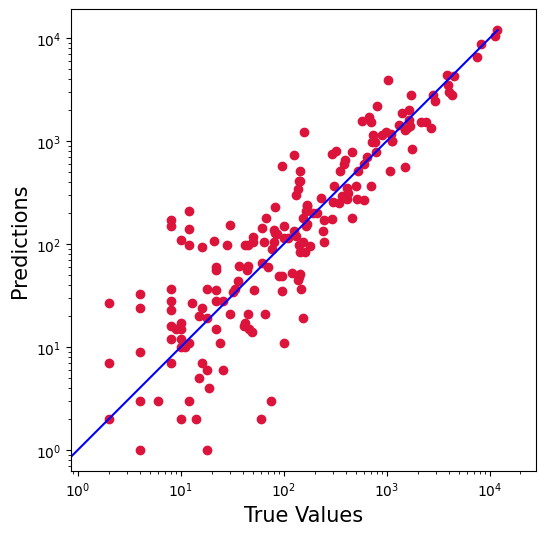

In [18]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

Parima to predict current year numbers

In [19]:
#dataframe to store prediction
data_task_1_arima=data_task_1.groupby(['STATE/UT']).sum().reset_index()
data_task_1_arima.drop('Year',axis=1,inplace=True)

In [20]:
data_task_1.columns

Index(['STATE/UT', 'Year', 'Boys SLL', 'Girls SLL', 'Grand total_x',
       'Grand total_y', '7-12 Years SLL', '12-16 Years SLL', '16-18 Years SLL',
       '7-12 Years No SLL', '12-16 Years No SLL', '16-18 Years No SLL',
       'Boys No SLL', 'Girls No SLL', 'Total No SLL'],
      dtype='object')

In [21]:
for i in tqdm(data_task_1['STATE/UT'].unique()):
  data_task_1_temp=data_task_1[data_task_1['STATE/UT']==i]
  for j in ['Boys SLL', '7-12 Years SLL', '12-16 Years SLL', '16-18 Years SLL', '7-12 Years No SLL', '12-16 Years No SLL', '16-18 Years No SLL', 'Boys No SLL']:
    data_task_1_temp1=data_task_1_temp[['Year',j]]
    model = pm.auto_arima(data_task_1_temp1.iloc[:,1:2].reset_index(drop=True), seasonal=False, error_action='ignore')
    predictions = model.predict(n_periods=1)
    idx=data_task_1_arima[data_task_1_arima['STATE/UT']==i].index.values[0]
    data_task_1_arima.at[idx,j]=int(predictions)

100%|██████████| 35/35 [03:48<00:00,  6.52s/it]


In [22]:
data_task_1_arima = data_task_1_arima.set_index('STATE/UT')
data_task_1_arima[data_task_1_arima < 0] = 0
data_task_1_arima = data_task_1_arima.reset_index()

In [23]:
data_task_1_arima['Grand total_x']=data_task_1_arima['16-18 Years SLL']+data_task_1_arima['12-16 Years SLL']+data_task_1_arima['7-12 Years SLL']
data_task_1_arima['Grand total_y']=data_task_1_arima['Grand total_x']+data_task_1_arima['16-18 Years No SLL']+data_task_1_arima['12-16 Years No SLL']+data_task_1_arima['7-12 Years No SLL']
data_task_1_arima['Girls SLL']=data_task_1_arima['Grand total_x']-data_task_1_arima['Boys SLL']
data_task_1_arima['Girls No SLL']=data_task_1_arima['Grand total_y']-data_task_1_arima['Grand total_x']-data_task_1_arima['Boys No SLL']

In [24]:
data_task_1=data_task_1_arima

Naive Bayes

In [25]:
boys = pd.DataFrame(columns = ['7-12 Years','12-16 Years','16-18 Years'], index = data_task_1['STATE/UT'])
girls = pd.DataFrame(columns = ['7-12 Years','12-16 Years','16-18 Years'], index = data_task_1['STATE/UT'])
for gender in ['Boys','Girls']:
  for age in ['7-12 Years','12-16 Years','16-18 Years']:
    for state in data_task_1['STATE/UT']:
      prob_y_state=data_task_1[data_task_1['STATE/UT']==state]['Grand total_x'].values[0]/data_task_1['Grand total_x'].sum()
      prob_y_age=data_task_1[age+" SLL"].sum()/data_task_1['Grand total_x'].sum()
      prob_y_gender=data_task_1[gender+" SLL"].sum()/data_task_1['Grand total_x'].sum()
      prob_y=data_task_1['Grand total_x'].sum()/data_task_1['Grand total_y'].sum()

      prob_n_state=data_task_1[data_task_1['STATE/UT']==state]['Total No SLL'].values[0]/data_task_1['Total No SLL'].sum()
      prob_n_age=data_task_1[age+" No SLL"].sum()/data_task_1['Total No SLL'].sum()
      prob_n_gender=data_task_1[gender+" No SLL"].sum()/data_task_1['Total No SLL'].sum()
      prob_n=data_task_1['Total No SLL'].sum()/data_task_1['Grand total_y'].sum()

      if(prob_y_state*prob_y_age*prob_y_gender*prob_y>prob_n_state*prob_n_age*prob_n_gender*prob_n):
        if gender=='Boys':
          boys.at[state,age]='YES'
        else:
          girls.at[state,age]='YES'
      else:
        if gender=='Boys':
          boys.at[state,age]='NO'
        else:
          girls.at[state,age]='NO'

In [26]:
boys

,7-12 Years,12-16 Years,16-18 Years
STATE/UT,,,
A&N Islands,NO,NO,NO
Andhra Pradesh,NO,NO,NO
Arunachal Pradesh,NO,NO,NO
Assam,NO,NO,NO
Bihar,NO,NO,NO
Chandigarh,NO,NO,NO
Chhattisgarh,YES,YES,YES
D&N Haveli,NO,NO,NO
Daman & Diu,NO,NO,NO


import numpy as np
from google.colab import autoviz
df_1008762405978829428 = autoviz.get_df('df_1008762405978829428')

def categorical_histogram(df, colname, figsize=(2, 1.2), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  _, ax = plt.subplots(figsize=figsize)
  bars = df[colname].value_counts()
  plt.barh(bars.index, bars.values, color=sns.palettes.mpl_palette(mpl_palette_name))
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(df_1008762405978829428, *['7-12 Years'], **{})
chart

import numpy as np
from google.colab import autoviz
df_1008762405978829428 = autoviz.get_df('df_1008762405978829428')

def categorical_histogram(df, colname, figsize=(2, 1.2), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  _, ax = plt.subplots(figsize=figsize)
  bars = df[colname].value_counts()
  plt.barh(bars.index, bars.values, color=sns.palettes.mpl_palette(mpl_palette_name))
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(df_1008762405978829428, *['12-16 Years'], **{})
chart

import numpy as np
from google.colab import autoviz
df_1008762405978829428 = autoviz.get_df('df_1008762405978829428')

def categorical_histogram(df, colname, figsize=(2, 1.2), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  _, ax = plt.subplots(figsize=figsize)
  bars = df[colname].value_counts()
  plt.barh(bars.index, bars.values, color=sns.palettes.mpl_palette(mpl_palette_name))
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(df_1008762405978829428, *['16-18 Years'], **{})
chart

import numpy as np
from google.colab import autoviz
df_1008762405978829428 = autoviz.get_df('df_1008762405978829428')

def heatmap(df, x_colname, y_colname, figsize=(2, 2), mpl_palette_name='viridis'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  import pandas as pd
  plt.subplots(figsize=figsize)
  df_2dhist = pd.DataFrame({
      x_label: grp[y_colname].value_counts()
      for x_label, grp in df.groupby(x_colname)
  })
  sns.heatmap(df_2dhist, cmap=mpl_palette_name)
  plt.xlabel(x_colname)
  plt.ylabel(y_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = heatmap(df_1008762405978829428, *['7-12 Years', '12-16 Years'], **{})
chart

import numpy as np
from google.colab import autoviz
df_1008762405978829428 = autoviz.get_df('df_1008762405978829428')

def heatmap(df, x_colname, y_colname, figsize=(2, 2), mpl_palette_name='viridis'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  import pandas as pd
  plt.subplots(figsize=figsize)
  df_2dhist = pd.DataFrame({
      x_label: grp[y_colname].value_counts()
      for x_label, grp in df.groupby(x_colname)
  })
  sns.heatmap(df_2dhist, cmap=mpl_palette_name)
  plt.xlabel(x_colname)
  plt.ylabel(y_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = heatmap(df_1008762405978829428, *['12-16 Years', '16-18 Years'], **{})
chart

Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [78]:
boys.T

STATE/UT,A&N Islands,Andhra Pradesh,Arunachal Pradesh,Assam,Bihar,Chandigarh,Chhattisgarh,D&N Haveli,Daman & Diu,Delhi UT,...,Odisha,Puducherry,Punjab,Rajasthan,Sikkim,Tamil Nadu,Tripura,Uttar Pradesh,Uttarakhand,West Bengal
7-12 Years,NO,NO,NO,NO,NO,NO,YES,NO,NO,NO,...,NO,NO,YES,NO,NO,YES,NO,YES,YES,YES
12-16 Years,NO,NO,NO,NO,NO,NO,YES,NO,NO,NO,...,NO,NO,YES,NO,NO,YES,NO,NO,YES,YES
16-18 Years,NO,NO,NO,NO,NO,NO,YES,NO,NO,NO,...,NO,NO,YES,NO,NO,YES,NO,NO,YES,YES


In [27]:
girls

,7-12 Years,12-16 Years,16-18 Years
STATE/UT,,,
A&N Islands,NO,NO,NO
Andhra Pradesh,NO,NO,NO
Arunachal Pradesh,NO,NO,NO
Assam,NO,NO,NO
Bihar,YES,NO,NO
Chandigarh,NO,NO,NO
Chhattisgarh,YES,YES,YES
D&N Haveli,NO,NO,NO
Daman & Diu,NO,NO,NO


In [79]:
girls.T

STATE/UT,A&N Islands,Andhra Pradesh,Arunachal Pradesh,Assam,Bihar,Chandigarh,Chhattisgarh,D&N Haveli,Daman & Diu,Delhi UT,...,Odisha,Puducherry,Punjab,Rajasthan,Sikkim,Tamil Nadu,Tripura,Uttar Pradesh,Uttarakhand,West Bengal
7-12 Years,NO,NO,NO,NO,YES,NO,YES,NO,NO,NO,...,NO,NO,YES,YES,NO,YES,NO,YES,YES,YES
12-16 Years,NO,NO,NO,NO,NO,NO,YES,NO,NO,NO,...,NO,NO,YES,NO,NO,YES,NO,NO,YES,YES
16-18 Years,NO,NO,NO,NO,NO,NO,YES,NO,NO,NO,...,NO,NO,YES,YES,NO,YES,NO,YES,YES,YES


-----------------------------------------------------------------------

------------------------------------------------------------------------------------------------------------------------------------------------

#2.Relation between punishment and recidivism (join data3 and data7)

Data processing

In [28]:
data7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Area_Name                  350 non-null    object
 1   Year                       350 non-null    int64 
 2   Sub_Group_Name             350 non-null    object
 3   Recidivism_New_Delinquent  350 non-null    int64 
 4   Recidivism_Old_Delinquent  350 non-null    int64 
 5   Recidivism_Total           350 non-null    int64 
dtypes: int64(4), object(2)
memory usage: 16.5+ KB


In [29]:
data7_task2_cleaned=data7.drop(['Sub_Group_Name','Recidivism_Total'],axis=1)

In [30]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 10 columns):
 #   Column                                                                         Non-Null Count  Dtype 
---  ------                                                                         --------------  ----- 
 0   Area_Name                                                                      349 non-null    object
 1   Year                                                                           349 non-null    int64 
 2   Juveniles_Acquitted_or_Otherwise_Disposed_of                                   349 non-null    int64 
 3   Juveniles_Arrested                                                             349 non-null    int64 
 4   Juveniles_Dealt_with_Fine                                                      349 non-null    int64 
 5   Juveniles_Released_on_Probation_and_placed_under_the_Care_of_Fit_Institutions  349 non-null    int64 
 6   Juveniles_Released_on_Probation_an

In [31]:
data_task2 = pd.merge(data3,data7_task2_cleaned,on=['Area_Name','Year'],how='inner')
data_task2.drop(['Area_Name','Year'],axis=1,inplace=True)
data_task2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349 entries, 0 to 348
Data columns (total 10 columns):
 #   Column                                                                         Non-Null Count  Dtype
---  ------                                                                         --------------  -----
 0   Juveniles_Acquitted_or_Otherwise_Disposed_of                                   349 non-null    int64
 1   Juveniles_Arrested                                                             349 non-null    int64
 2   Juveniles_Dealt_with_Fine                                                      349 non-null    int64
 3   Juveniles_Released_on_Probation_and_placed_under_the_Care_of_Fit_Institutions  349 non-null    int64
 4   Juveniles_Released_on_Probation_and_placed_under_the_Care_of_Parent_Guardian   349 non-null    int64
 5   Juveniles_Sent_Home_after_Advice_or_Admonition                                 349 non-null    int64
 6   Juveniles_Sent_to_Special_Home            

Regression

In [81]:
X=data_task2.iloc[:,:-2]
y1=data_task2.iloc[:,-2:-1]
y2=data_task2.iloc[:,-1:]

In [82]:
lr1=LinearRegression()
lr1.fit(X,y1)
lr2=LinearRegression()
lr2.fit(X,y2)

LinearRegression()

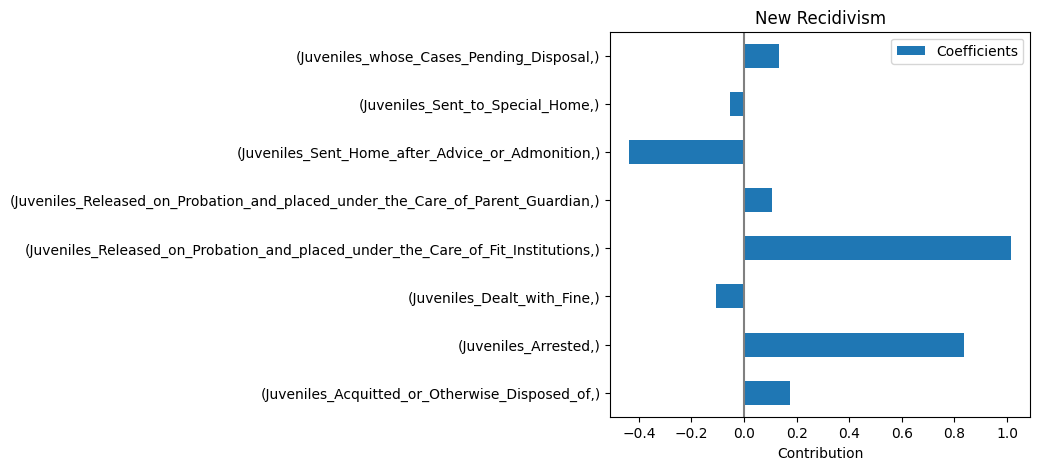

In [34]:
coefs = pd.DataFrame(lr1.coef_.reshape(8,1), columns=["Coefficients"], index=X.columns.values.reshape(8,1))
coefs.plot.barh(figsize=(7, 5))
plt.title("New Recidivism")
plt.axvline(x=0, color=".5")
plt.xlabel("Contribution")
plt.subplots_adjust(left=0.3)

Using Random Forest

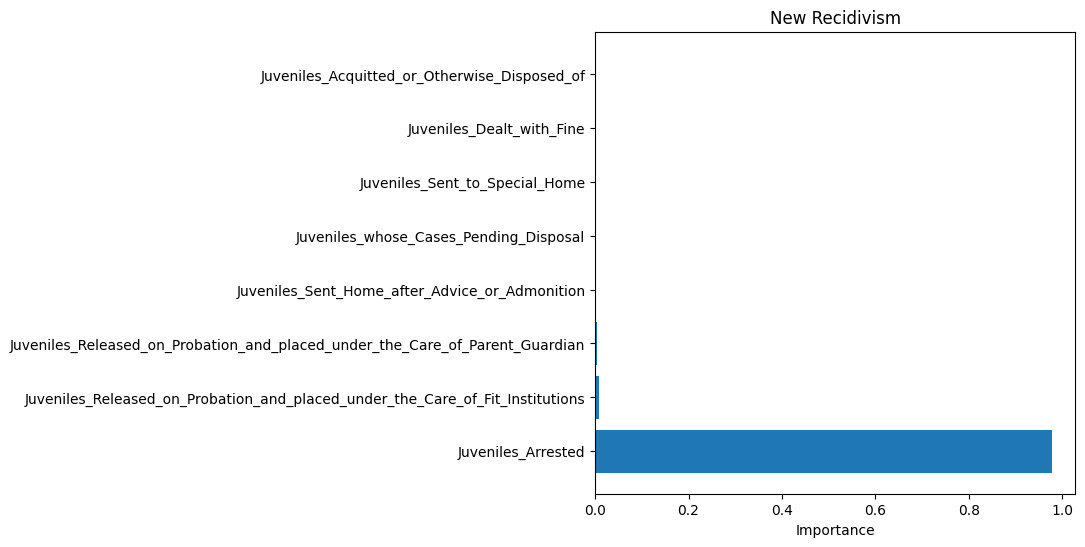

In [83]:
rf = RandomForestRegressor()
rf.fit(X, y1)

# Get feature importances
importances = rf.feature_importances_
feature_names = X.columns

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.barh(range(X.shape[1]), importances[indices], align='center')
plt.yticks(range(X.shape[1]), feature_names[indices])
plt.title("New Recidivism")
plt.xlabel("Importance")
plt.subplots_adjust(left=0.3)
plt.show()

Old Recidivism using linear regression

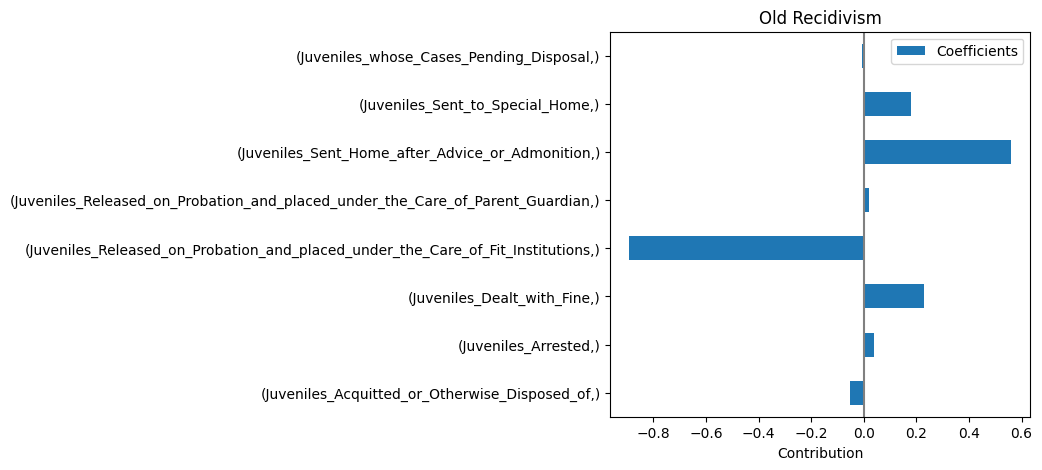

In [84]:
coefs = pd.DataFrame(lr2.coef_.reshape(8,1), columns=["Coefficients"], index=X.columns.values.reshape(8,1))
coefs.plot.barh(figsize=(7, 5))
plt.title("Old Recidivism")
plt.axvline(x=0, color=".5")
plt.xlabel("Contribution")
plt.subplots_adjust(left=0.3)

Using Random Forest

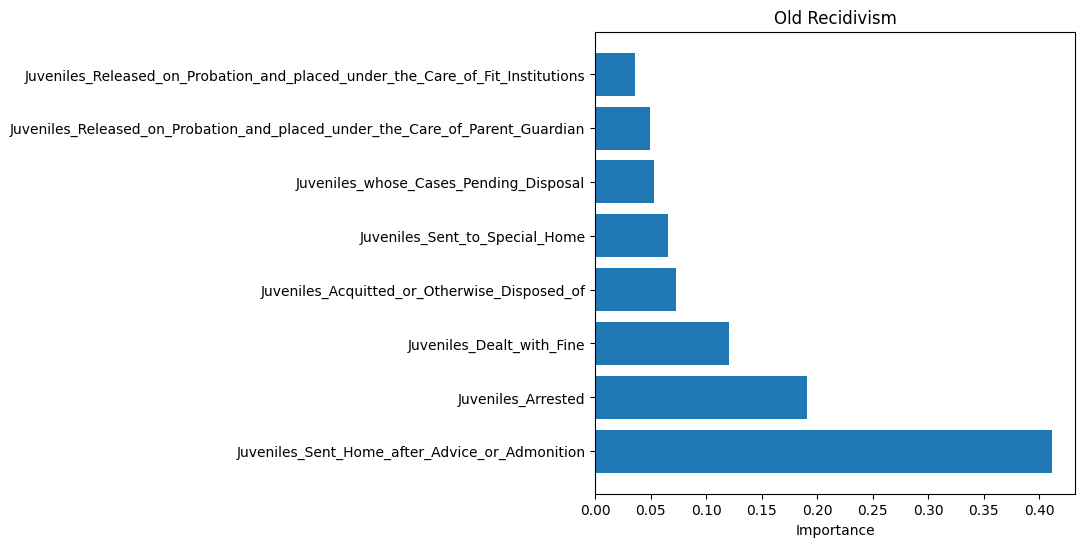

In [85]:
rf = RandomForestRegressor()
rf.fit(X, y2)

# Get feature importances
importances = rf.feature_importances_
feature_names = X.columns

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.barh(range(X.shape[1]), importances[indices], align='center')
plt.yticks(range(X.shape[1]), feature_names[indices])
plt.title("Old Recidivism")
plt.xlabel("Importance")
plt.subplots_adjust(left=0.3)
plt.show()

--------------------------------------------------------------------------------

--------------------------------------------------------------------------------

In [38]:
data4.drop('Sub_Group_Name',axis=1,inplace=True)

In [39]:
data5.drop('Sub_Group_Name',axis=1,inplace=True)

In [40]:
data6.drop('Sub_Group_Name',axis=1,inplace=True)

#3.What is biggest reason for juvenile crime?(Joined dataset-data4 to data6)

In [41]:
data_task3 = pd.merge(data4,data5,on=['Area_Name','Year'],how='inner')
data_task3.drop(['Education_Total','Economic_Set_up_Total'],axis=1,inplace=True)
data_task3 = pd.merge(data_task3,data6,on=['Area_Name','Year'],how='inner')
data_task3.drop(['Family_back_ground_Total'],axis=1,inplace=True)
data_task3['Total']=data4['Education_Total']+data5['Economic_Set_up_Total']+data6['Family_back_ground_Total']
data_task3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 350 entries, 0 to 349
Data columns (total 16 columns):
 #   Column                                                        Non-Null Count  Dtype 
---  ------                                                        --------------  ----- 
 0   Area_Name                                                     350 non-null    object
 1   Year                                                          350 non-null    int64 
 2   Education_Above_Primary_but_below_Matric_or_Higher_Secondary  350 non-null    int64 
 3   Education_Illiterate                                          350 non-null    int64 
 4   Education_Matric_or_Higher_Secondary_&_above                  350 non-null    int64 
 5   Education_Upto_primary                                        350 non-null    int64 
 6   Economic_Set_up_Annual_Income_250001_to_50000                 350 non-null    int64 
 7   Economic_Set_up_Annual_Income_upto_Rs_25000                   350 non-null    in

Regression

In [89]:
X=data_task3.iloc[:,2:-1]
y=data_task3.iloc[:,-1:]

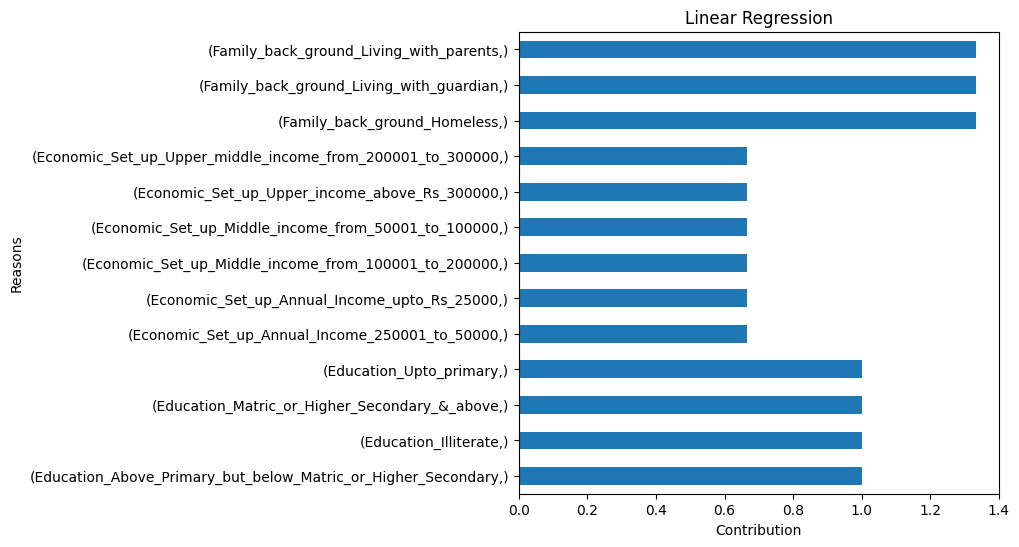

In [92]:
lr=LinearRegression()
lr.fit(X,y)

coefs = pd.DataFrame(lr.coef_.reshape(13,1), columns=["Coefficients"], index=X.columns.values.reshape(13,1))
coefs.plot.barh(figsize=(8, 6),legend=None)
plt.title("Linear Regression")
plt.ylabel("Reasons")
plt.axvline(x=0, color=".5")
plt.xlabel("Contribution")
plt.subplots_adjust(left=0.3)

Using Random Forest

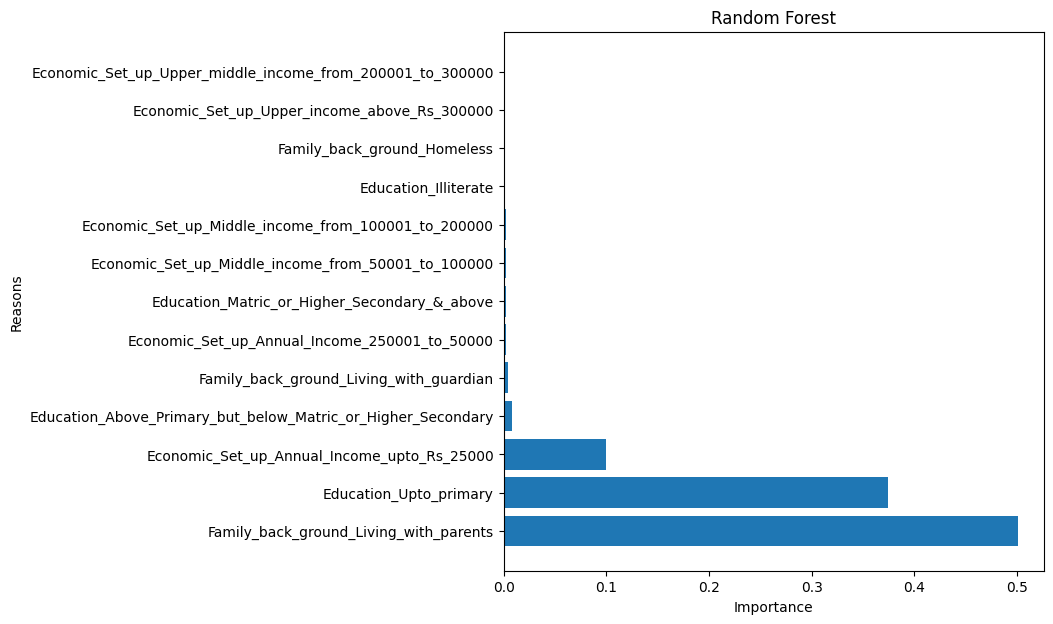

In [93]:
rf = RandomForestRegressor()
rf.fit(X, y)

# Get feature importances
importances = rf.feature_importances_
feature_names = X.columns

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(9, 7))
plt.barh(range(X.shape[1]), importances[indices], align='center')
plt.yticks(range(X.shape[1]), feature_names[indices])
plt.title("Random Forest")
plt.ylabel("Reasons")
plt.xlabel("Importance")
plt.subplots_adjust(left=0.3)
plt.show()

--------------------------------------------------------------------------------

--------------------------------------------------------------------------------

Recidivism refers to the act of reoffending or returning to criminal behavior after being released from prison or completing a sentence. In other words, it is a measure of how likely a person is to commit a crime again after they have been convicted and punished for a previous offense.

Recidivism is a significant problem in the criminal justice system, as it can lead to a cycle of crime, punishment, and incarceration. High rates of recidivism can also indicate that the system is not effectively addressing the root causes of criminal behavior and may be failing to provide adequate support and rehabilitation for offenders.

In [45]:
data7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Area_Name                  350 non-null    object
 1   Year                       350 non-null    int64 
 2   Sub_Group_Name             350 non-null    object
 3   Recidivism_New_Delinquent  350 non-null    int64 
 4   Recidivism_Old_Delinquent  350 non-null    int64 
 5   Recidivism_Total           350 non-null    int64 
dtypes: int64(4), object(2)
memory usage: 16.5+ KB


In [46]:
data7.drop('Sub_Group_Name',axis=1,inplace=True)

#Which State requires better rehabilitation facilities.(Done using clustering)
#Given State, who to be on a look out for?(Arima+Naive bias, 3 class classification)


Combining data for all years

In [47]:
data7_clustering=data7.drop('Year',axis=1)

In [48]:
data7_clustering=data7_clustering.groupby(['Area_Name']).sum().reset_index()

In [49]:
data7_clustering.head()

,Area_Name,Recidivism_New_Delinquent,Recidivism_Old_Delinquent,Recidivism_Total
0,Andaman & Nicobar Islands,322,17,339
1,Andhra Pradesh,16910,3004,19914
2,Arunachal Pradesh,1136,57,1193
3,Assam,3677,1276,4953
4,Bihar,6327,544,6871


In [50]:
scaler = StandardScaler()

In [51]:
data7_clustering_new=data7_clustering[['Recidivism_New_Delinquent']]
data7_clustering_new = scaler.fit_transform(data7_clustering_new)

In [52]:
data7_clustering_old=data7_clustering[['Recidivism_Old_Delinquent']]
data7_clustering_old = scaler.fit_transform(data7_clustering_old)

elbow method for optimal k

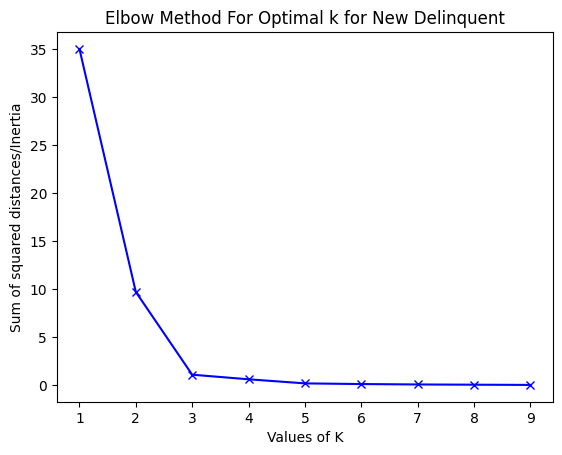

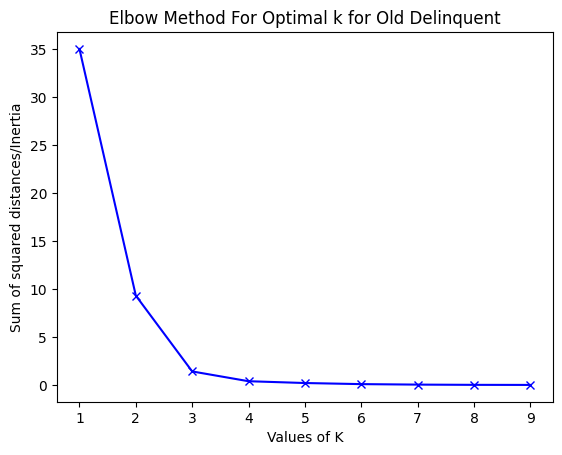

In [53]:
ssd1 = []
ssd2 = []
K = range(1,10)
for num_clusters in K :
 kmeans1 = KMeans(n_clusters=num_clusters,n_init=10)
 kmeans1.fit(data7_clustering_new)
 ssd1.append(kmeans1.inertia_)
 kmeans2 = KMeans(n_clusters=num_clusters,n_init=10)
 kmeans2.fit(data7_clustering_old)
 ssd2.append(kmeans2.inertia_)

plt.xlabel('Values of K')
plt.ylabel('Sum of squared distances/Inertia')
plt.plot(K,ssd1,'bx-')
plt.title('Elbow Method For Optimal k for New Delinquent')
plt.show()
plt.xlabel('Values of K')
plt.ylabel('Sum of squared distances/Inertia')
plt.plot(K,ssd2,'bx-')
plt.title('Elbow Method For Optimal k for Old Delinquent')
plt.show()

In [54]:
# Based on the elbow method, choose the optimal value of k
k = 3
# Fit the KMeans model to the data and obtain cluster labels
kmeans1 = KMeans(n_clusters=k,n_init=10)
labels1 = kmeans1.fit_predict(data7_clustering_new)
kmeans2 = KMeans(n_clusters=k,n_init=10)
labels2 = kmeans2.fit_predict(data7_clustering_old)
# Add the cluster labels to the original dataset
data7_clustering['new_cluster'] = labels1+1
data7_clustering['old_cluster'] = labels2+1

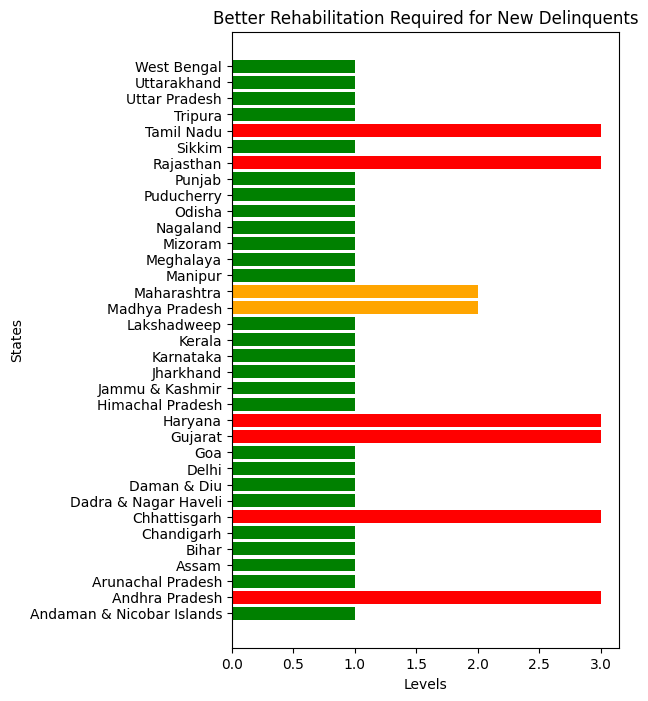

In [55]:
plt.figure(figsize=(5, 8))
new_color = [{p==3: 'red', p==2: 'orange', p==1: 'green'}[True] for p in data7_clustering['new_cluster']]
plt.barh( data7_clustering['Area_Name'], data7_clustering['new_cluster'],color=new_color)
plt.xlabel("Levels")
plt.ylabel("States")
plt.title("Better Rehabilitation Required for New Delinquents")
plt.show()

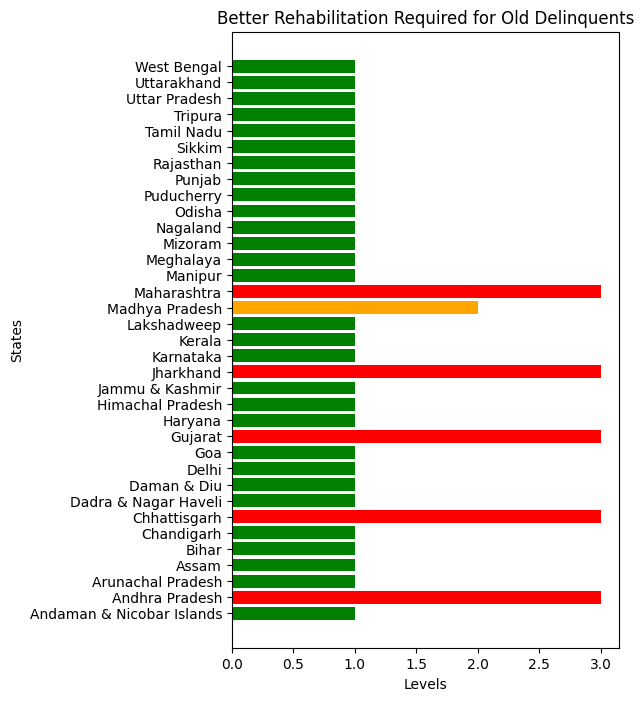

In [56]:
plt.figure(figsize=(5, 8))
old_color = [{p==3: 'red', p==2: 'orange', p==1: 'green'}[True] for p in data7_clustering['old_cluster']]
plt.barh( data7_clustering['Area_Name'], data7_clustering['old_cluster'],color=old_color)
plt.xlabel("Levels")
plt.ylabel("States")
plt.title("Better Rehabilitation Required for Old Delinquents")
plt.show()

Applying arima model to predict current year numbers from past year data

In [57]:
data7_arima_test=data7[data7['Area_Name']=='Gujarat']
data7_arima_test.head()

,Area_Name,Year,Recidivism_New_Delinquent,Recidivism_Old_Delinquent,Recidivism_Total
11,Gujarat,2001,4082,288,4370
46,Gujarat,2002,3109,226,3335
81,Gujarat,2003,2313,404,2717
116,Gujarat,2004,2363,326,2689
151,Gujarat,2005,2404,344,2748


In [58]:
data7_arima_test=data7_arima_test[['Year','Recidivism_New_Delinquent']]
data7_arima_test.head()

,Year,Recidivism_New_Delinquent
11,2001,4082
46,2002,3109
81,2003,2313
116,2004,2363
151,2005,2404


In [59]:
model = pm.auto_arima(data7_arima_test.iloc[:-1,1:2].reset_index(drop=True), seasonal=False, error_action='ignore')
# Make predictions on the test set
predictions = model.predict(n_periods=1)
int(predictions)

2080

<Axes: >

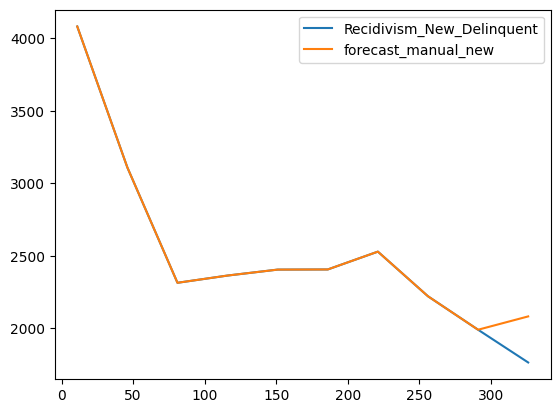

In [60]:
data7_arima_pred=data7_arima_test
data7_arima_pred['forecast_manual_new'] =list(data7_arima_test.iloc[:-1,1:2].values.ravel()) + list(predictions)
data7_arima_pred[['Recidivism_New_Delinquent','forecast_manual_new']].plot()

Doing this for every state and both columns and adding the orignal data

In [61]:
#non-recidivism
data_non_recidivism=data1[['STATE/UT','Year','Grand total']]
data_non_recidivism=data_non_recidivism.groupby(['STATE/UT','Year']).sum().reset_index()
data_non_recidivism.rename(columns = {'STATE/UT':'Area_Name','Grand total':'Non_Recidivism'}, inplace = True)

In [62]:
data_non_recidivism['Area_Name'].unique()

array(['A&N Islands', 'Andhra Pradesh', 'Arunachal Pradesh', 'Assam',
       'Bihar', 'Chandigarh', 'Chhattisgarh', 'D&N Haveli', 'Daman & Diu',
       'Delhi UT', 'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh',
       'Jammu & Kashmir', 'Jharkhand', 'Karnataka', 'Kerala',
       'Lakshadweep', 'Madhya Pradesh', 'Maharashtra', 'Manipur',
       'Meghalaya', 'Mizoram', 'Nagaland', 'Odisha', 'Puducherry',
       'Punjab', 'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Tripura',
       'Uttar Pradesh', 'Uttarakhand', 'West Bengal'], dtype=object)

In [63]:
data7['Area_Name'].unique()

array(['Andaman & Nicobar Islands', 'Andhra Pradesh', 'Arunachal Pradesh',
       'Assam', 'Bihar', 'Chandigarh', 'Chhattisgarh',
       'Dadra & Nagar Haveli', 'Daman & Diu', 'Delhi', 'Goa', 'Gujarat',
       'Haryana', 'Himachal Pradesh', 'Jammu & Kashmir', 'Jharkhand',
       'Karnataka', 'Kerala', 'Lakshadweep', 'Madhya Pradesh',
       'Maharashtra', 'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland',
       'Odisha', 'Puducherry', 'Punjab', 'Rajasthan', 'Sikkim',
       'Tamil Nadu', 'Tripura', 'Uttar Pradesh', 'Uttarakhand',
       'West Bengal'], dtype=object)

In [64]:
#correcting state names
idx=data_non_recidivism[data_non_recidivism['Area_Name']=='A&N Islands'].index.values
data_non_recidivism.loc[idx,'Area_Name']='Andaman & Nicobar Islands'
idx=data_non_recidivism[data_non_recidivism['Area_Name']=='D&N Haveli'].index.values
data_non_recidivism.loc[idx,'Area_Name']='Dadra & Nagar Haveli'
idx=data_non_recidivism[data_non_recidivism['Area_Name']=='Delhi UT'].index.values
data_non_recidivism.loc[idx,'Area_Name']='Delhi'

In [65]:
data_non_recidivism['Area_Name'].unique()

array(['Andaman & Nicobar Islands', 'Andhra Pradesh', 'Arunachal Pradesh',
       'Assam', 'Bihar', 'Chandigarh', 'Chhattisgarh',
       'Dadra & Nagar Haveli', 'Daman & Diu', 'Delhi', 'Goa', 'Gujarat',
       'Haryana', 'Himachal Pradesh', 'Jammu & Kashmir', 'Jharkhand',
       'Karnataka', 'Kerala', 'Lakshadweep', 'Madhya Pradesh',
       'Maharashtra', 'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland',
       'Odisha', 'Puducherry', 'Punjab', 'Rajasthan', 'Sikkim',
       'Tamil Nadu', 'Tripura', 'Uttar Pradesh', 'Uttarakhand',
       'West Bengal'], dtype=object)

In [66]:
#merging two dataframes
data7_arima=pd.merge(data_non_recidivism,data7,on=['Area_Name','Year'],how='inner')
data7_arima['Non_Recidivism']=data7_arima['Non_Recidivism']-data7_arima['Recidivism_Total']

In [67]:
data7_arima

,Area_Name,Year,Non_Recidivism,Recidivism_New_Delinquent,Recidivism_Old_Delinquent,Recidivism_Total
0,Andaman & Nicobar Islands,2001,16,16,0,16
1,Andaman & Nicobar Islands,2002,7,6,0,6
2,Andaman & Nicobar Islands,2003,9,9,0,9
3,Andaman & Nicobar Islands,2004,14,13,0,13
4,Andaman & Nicobar Islands,2005,14,10,0,10
...,...,...,...,...,...,...
345,West Bengal,2006,164,123,1,124
346,West Bengal,2007,113,140,5,145
347,West Bengal,2008,740,648,59,707
348,West Bengal,2009,206,173,22,195


import numpy as np
from google.colab import autoviz
df_5778013892410122942 = autoviz.get_df('df_5778013892410122942')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_5778013892410122942, *['Non_Recidivism'], **{})
chart

import numpy as np
from google.colab import autoviz
df_8567958495582223147 = autoviz.get_df('df_8567958495582223147')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_8567958495582223147, *['Recidivism_New_Delinquent'], **{})
chart

import numpy as np
from google.colab import autoviz
df_9191642014264118519 = autoviz.get_df('df_9191642014264118519')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_9191642014264118519, *['Recidivism_Old_Delinquent'], **{})
chart

import numpy as np
from google.colab import autoviz
df_7143594217385583011 = autoviz.get_df('df_7143594217385583011')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_7143594217385583011, *['Recidivism_Total'], **{})
chart

import numpy as np
from google.colab import autoviz
df_2438599655846024533 = autoviz.get_df('df_2438599655846024533')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_2438599655846024533, *['Non_Recidivism'], **{})
chart

import numpy as np
from google.colab import autoviz
df_198672110902549602 = autoviz.get_df('df_198672110902549602')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_198672110902549602, *['Recidivism_New_Delinquent'], **{})
chart

import numpy as np
from google.colab import autoviz
df_8205533920679195409 = autoviz.get_df('df_8205533920679195409')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_8205533920679195409, *['Recidivism_Old_Delinquent'], **{})
chart

import numpy as np
from google.colab import autoviz
df_6709961155534983334 = autoviz.get_df('df_6709961155534983334')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_6709961155534983334, *['Recidivism_Total'], **{})
chart

import numpy as np
from google.colab import autoviz
df_137458324139208514 = autoviz.get_df('df_137458324139208514')

def scatter_plots(df, colname_pairs, scatter_plot_size=2.5, size=8, alpha=.6):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * scatter_plot_size, scatter_plot_size))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    ax.scatter(df[x_colname], df[y_colname], s=size, alpha=alpha)
    plt.xlabel(x_colname)
    plt.ylabel(y_colname)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(df_137458324139208514, *[[['Non_Recidivism', 'Recidivism_New_Delinquent'], ['Recidivism_New_Delinquent', 'Recidivism_Old_Delinquent'], ['Recidivism_Old_Delinquent', 'Recidivism_Total']]], **{})
chart

import numpy as np
from google.colab import autoviz
df_1489205156852426404 = autoviz.get_df('df_1489205156852426404')

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figsize=(2.5, 1.3), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df_1489205156852426404, *['Year', 'Non_Recidivism', None], **{})
chart

import numpy as np
from google.colab import autoviz
df_807319600402803769 = autoviz.get_df('df_807319600402803769')

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figsize=(2.5, 1.3), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df_807319600402803769, *['Year', 'Recidivism_New_Delinquent', None], **{})
chart

import numpy as np
from google.colab import autoviz
df_1444358069792907587 = autoviz.get_df('df_1444358069792907587')

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figsize=(2.5, 1.3), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df_1444358069792907587, *['Year', 'Recidivism_Old_Delinquent', None], **{})
chart

import numpy as np
from google.colab import autoviz
df_3131245896205398699 = autoviz.get_df('df_3131245896205398699')

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figsize=(2.5, 1.3), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df_3131245896205398699, *['Year', 'Recidivism_Total', None], **{})
chart

Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [68]:
#making dataframe to store next year prediction
data_recidivism_arima=data7.drop('Year',axis=1)

In [69]:
data_recidivism_arima.head()

,Area_Name,Recidivism_New_Delinquent,Recidivism_Old_Delinquent,Recidivism_Total
0,Andaman & Nicobar Islands,16,0,16
1,Andhra Pradesh,1392,173,1565
2,Arunachal Pradesh,130,7,137
3,Assam,248,5,253
4,Bihar,576,10,586


In [70]:
data_recidivism_arima=data_recidivism_arima.groupby(['Area_Name']).sum().reset_index()
data_recidivism_arima['Non_Recidivism']=data_recidivism_arima['Recidivism_Total']

Calculating Error

In [71]:
data_recidivism_arima_test=data7_arima[data7_arima['Year']!=2010]
data_recidivism_arima_real=data7_arima[data7_arima['Year']==2010]

In [72]:
for i in data_recidivism_arima.Area_Name:
  data7_arima_temp=data_recidivism_arima_test[data_recidivism_arima_test['Area_Name']==i]
  #print(data7_arima_temp[['Year','Recidivism_Old_Delinquent']])
  #break
  for j in data7_arima_temp.columns[2:-1]:
    #print(j)
    #print(data7_arima_temp[['Year',j]])
    data7_arima_temp1=data7_arima_temp[['Year',j]]
    model = pm.auto_arima(data7_arima_temp1.iloc[:,1:2].reset_index(drop=True), seasonal=False, error_action='ignore')
    predictions = model.predict(n_periods=1)
    idx=data_recidivism_arima[data_recidivism_arima['Area_Name']==i].index.values[0]
    data_recidivism_arima.at[idx,j]=int(predictions)

In [73]:
y_pred=data_recidivism_arima[['Non_Recidivism', 'Recidivism_New_Delinquent', 'Recidivism_Old_Delinquent']].values.ravel()
y_test=data_recidivism_arima_real[['Non_Recidivism', 'Recidivism_New_Delinquent', 'Recidivism_Old_Delinquent']].values.ravel()

print(mean_absolute_error(y_test,y_pred))

150.45714285714286


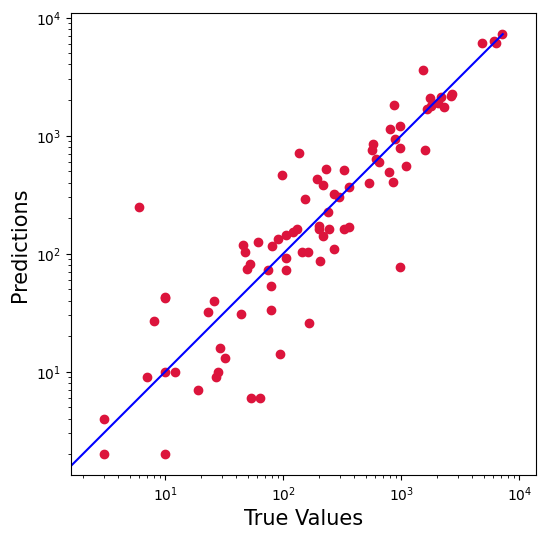

In [74]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

Calculating current years number

In [75]:
for i in data_recidivism_arima.Area_Name:
  data7_arima_temp=data7_arima[data7_arima['Area_Name']==i]
  #print(data7_arima_temp[['Year','Recidivism_Old_Delinquent']])
  #break
  for j in data7_arima_temp.columns[2:-1]:
    #print(j)
    #print(data7_arima_temp[['Year',j]])
    data7_arima_temp1=data7_arima_temp[['Year',j]]
    model = pm.auto_arima(data7_arima_temp1.iloc[:,1:2].reset_index(drop=True), seasonal=False, error_action='ignore')
    predictions = model.predict(n_periods=1)
    idx=data_recidivism_arima[data_recidivism_arima['Area_Name']==i].index.values[0]
    data_recidivism_arima.at[idx,j]=int(predictions)

In [76]:
data_recidivism_arima['Recidivism_Total']=data_recidivism_arima['Recidivism_New_Delinquent']+data_recidivism_arima['Recidivism_Old_Delinquent']

Applying Naive bayes from user input

In [77]:
for state in data_recidivism_arima.Area_Name:
  prob_state_new=data_recidivism_arima[data_recidivism_arima['Area_Name']==state]['Recidivism_New_Delinquent'].values[0]/data_recidivism_arima['Recidivism_New_Delinquent'].sum()
  prob_new=data_recidivism_arima['Recidivism_New_Delinquent'].sum()/(data_recidivism_arima['Recidivism_New_Delinquent'].sum()+data_recidivism_arima['Recidivism_Old_Delinquent'].sum()+data_recidivism_arima['Non_Recidivism'].sum())
  prob_state_old=data_recidivism_arima[data_recidivism_arima['Area_Name']==state]['Recidivism_Old_Delinquent'].values[0]/data_recidivism_arima['Recidivism_Old_Delinquent'].sum()
  prob_old=data_recidivism_arima['Recidivism_Old_Delinquent'].sum()/(data_recidivism_arima['Recidivism_New_Delinquent'].sum()+data_recidivism_arima['Recidivism_Old_Delinquent'].sum()+data_recidivism_arima['Non_Recidivism'].sum())
  prob_state_non=data_recidivism_arima[data_recidivism_arima['Area_Name']==state]['Non_Recidivism'].values[0]/data_recidivism_arima['Non_Recidivism'].sum()
  prob_non=data_recidivism_arima['Non_Recidivism'].sum()/(data_recidivism_arima['Recidivism_New_Delinquent'].sum()+data_recidivism_arima['Recidivism_Old_Delinquent'].sum()+data_recidivism_arima['Non_Recidivism'].sum())

  if(prob_state_new*prob_new>prob_state_old*prob_old):
    if(prob_state_new*prob_new>prob_state_non*prob_non):
      if(prob_state_old*prob_old>prob_state_non*prob_non):
        print(state," : Recent Offenders--Old Offenders--New Offenders")
      else:
        print(state," : Recent Offenders--New Offenders--Old Offenders")
    else:
      print(state," : New Offenders--Recent Offenders--Old Offenders")
  else:
    if(prob_state_old*prob_old>prob_state_non*prob_non):
      if(prob_state_new*prob_new>prob_state_non*prob_non):
        print(state," : Old Offenders--Recent Offenders--New Offenders")
      else:
        print(state," : Old Offenders--New Offenders--Recent Offenders")
    else:
      print(state," : New Offenders--Old Offenders--Recent Offenders")


Andaman & Nicobar Islands  : Recent Offenders--New Offenders--Old Offenders
Andhra Pradesh  : New Offenders--Recent Offenders--Old Offenders
Arunachal Pradesh  : New Offenders--Recent Offenders--Old Offenders
Assam  : New Offenders--Recent Offenders--Old Offenders
Bihar  : New Offenders--Recent Offenders--Old Offenders
Chandigarh  : New Offenders--Recent Offenders--Old Offenders
Chhattisgarh  : New Offenders--Recent Offenders--Old Offenders
Dadra & Nagar Haveli  : New Offenders--Old Offenders--Recent Offenders
Daman & Diu  : New Offenders--Recent Offenders--Old Offenders
Delhi  : New Offenders--Recent Offenders--Old Offenders
Goa  : New Offenders--Recent Offenders--Old Offenders
Gujarat  : Recent Offenders--New Offenders--Old Offenders
Haryana  : New Offenders--Recent Offenders--Old Offenders
Himachal Pradesh  : New Offenders--Recent Offenders--Old Offenders
Jammu & Kashmir  : New Offenders--Recent Offenders--Old Offenders
Jharkhand  : New Offenders--Recent Offenders--Old Offenders
Kar